In [465]:
from db_utils import RDSDatabaseConnector, load_credentials
from format import DataFormat
import pandas as pd
from plotter import Plotter
from transform import DataFrameTransform
from db_utils import load_data
from info import DataFrameInfo
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

######################################
# Database
# Extract data and save to csv
######################################
# cred_dict = load_credentials()
# rds_con = RDSDatabaseConnector(cred_dict)
# df = rds_con.extract_rds_dataframe('loan_payments')
# RDSDatabaseConnector.save_to_csv(df, "loan_data.csv", index=False)
# RDSDatabaseConnector.csv_to_excel('loan_data')

Dataframe Shape:
(54231, 44)
                                % Null
funded_amount                 5.544799
term                          8.799395
int_rate                      9.531449
employment_length             3.905515
mths_since_last_delinq       57.166565
mths_since_last_record       88.602460
last_payment_date             0.134609
next_payment_date            60.127971
last_credit_pull_date         0.012908
collections_12_mths_ex_med    0.094042
mths_since_last_major_derog  86.172116


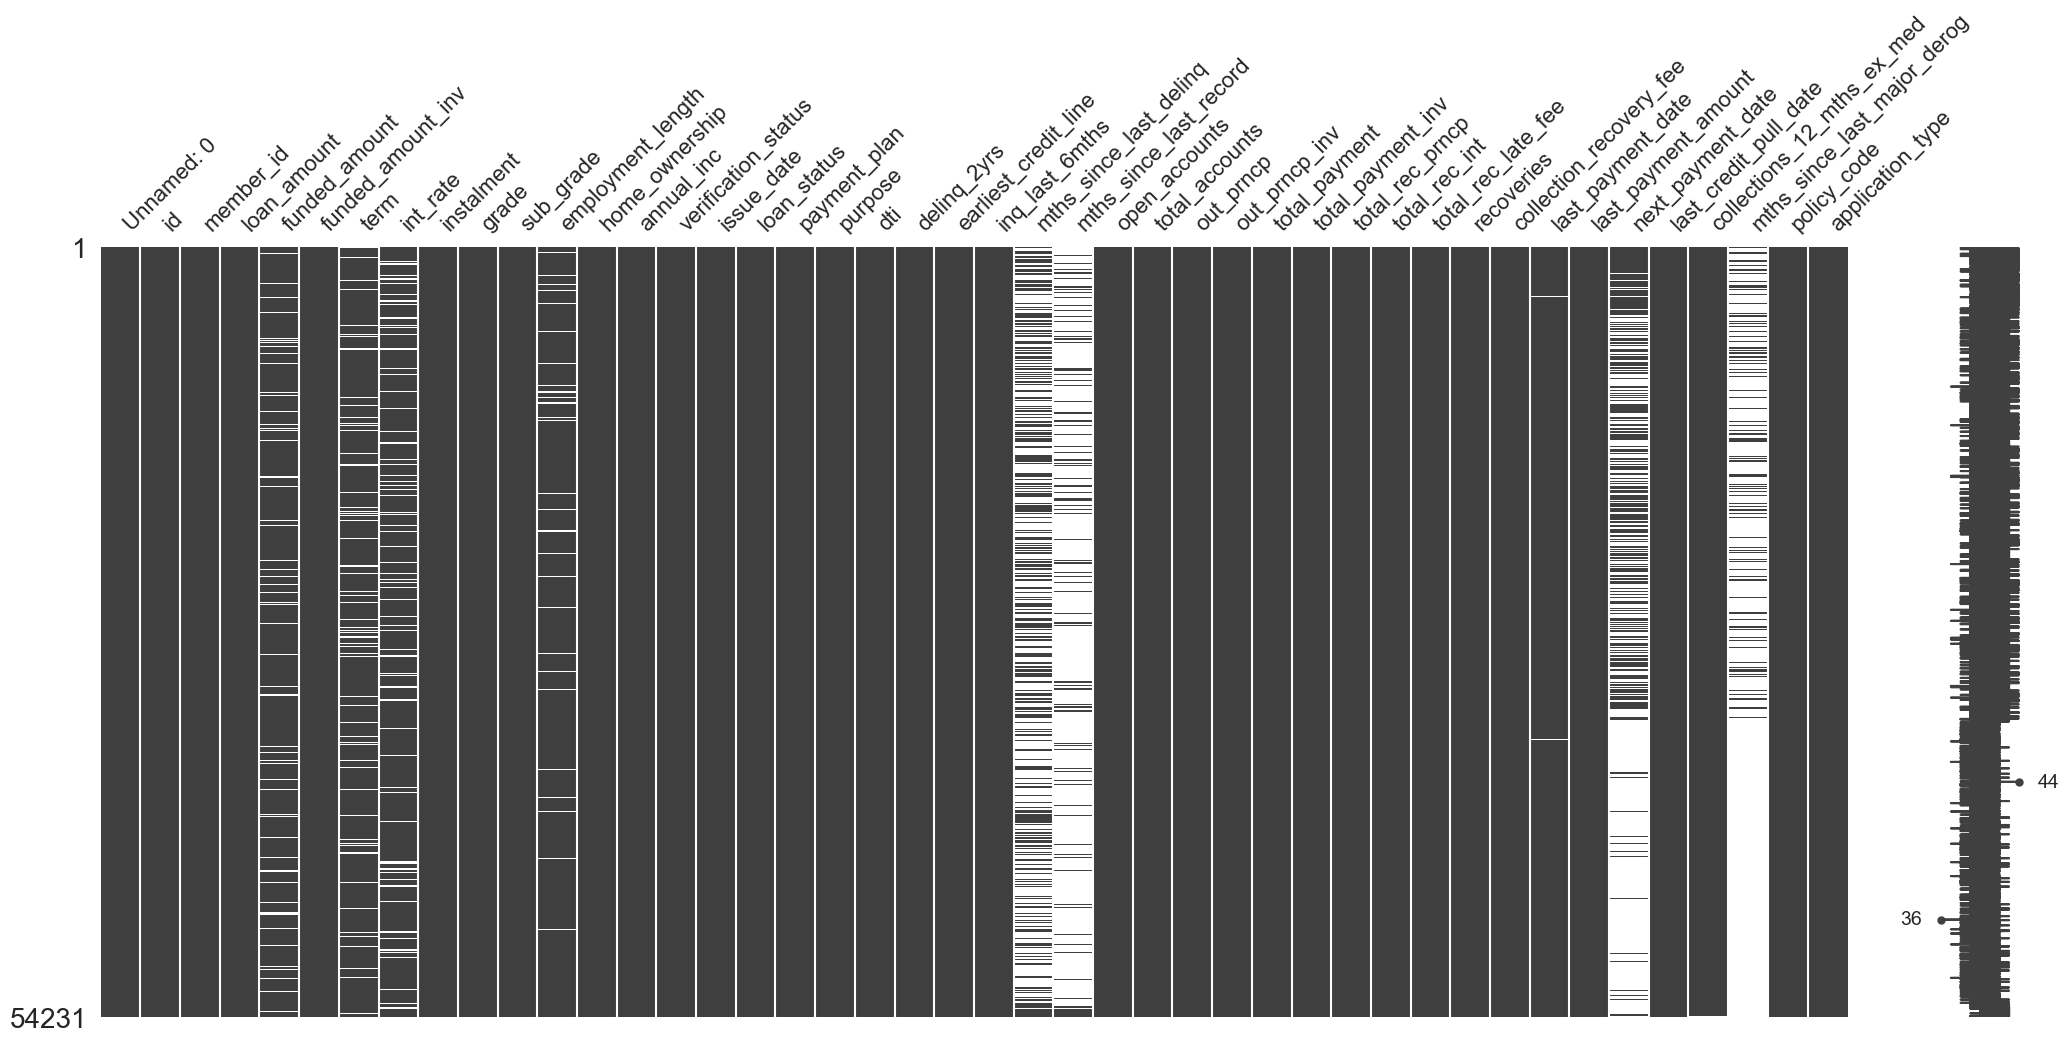

In [466]:
df = load_data("/dataset/loan_data.csv")
Info = DataFrameInfo(df)

print(Info.get_shape())
print(Info.percentage_null())

plt = Plotter(df)

numerical_cols = ['loan_amount',
                  'funded_amount_inv', 'int_rate', 'instalment', 'dti', 'total_payment', 'total_accounts', 'mths_since_last_major_derog', 'collections_12_mths_ex_med', 'recoveries', 'open_accounts', 'annual_inc']

plt.missing_nulls_vis()

In [467]:
Transformer = DataFormat(df)
# Convert n and y to bool values
Transformer.string_to_boolean('payment_plan')

[ True]


In [468]:
# String dates to date format
string_dates = ['last_credit_pull_date', 'next_payment_date',
                'last_payment_date', 'earliest_credit_line', 'issue_date']

Transformer.strings_to_dates(string_dates)

In [469]:
# Cols to num
string_to_num_cols = ['term', 'employment_length']
numerical_cols = ['term', 'mths_since_last_record',
                  'mths_since_last_major_derog', 'mths_since_last_delinq', 'mths_since_last_record', 'delinq_2yrs']

# Month to intiger
Transformer.extract_num_from_string(string_to_num_cols)
Transformer.numerical_cols(numerical_cols)

# we don't convert these cols : 'mths_since_last_record', 'mths_since_last_major_derog' to int since they include 0 months since last to signify recent entry and null for NO entry
Transformer.to_int(['term', 'open_accounts', 'total_accounts',
                    'collections_12_mths_ex_med', 'delinq_2yrs', 'employment_length', 'funded_amount'])

Transformer.round_float('collection_recovery_fee', 2)

In [470]:
# Before we convert to category columns we manage unique case with NMCAR null values

# Before we convert categories we have to handle unique case of columns:
# mths_since_last_delinq 57.17
# mths_since_last_record 88.60
# mths_since_last_major_derog  86.17

bins = [np.nan, 0, 36, 72, 108, 146]
bin_labels = ['Never', '1-3 Years',
              '4-6 Years', '7-9 Years', '10-12 Years']

bin_cols = ['mths_since_last_delinq', 'mths_since_last_record',
            'mths_since_last_major_derog']

for col in bin_cols:
    Transformer.df[col] = pd.cut(Transformer.df[col], bins=bins,
                                 labels=bin_labels, right=True, include_lowest=True)
    Transformer.df[col] = Transformer.df[col].fillna('Never')

categories = ['grade', 'sub_grade', 'home_ownership',
              'verification_status', 'loan_status', 'purpose', 'employment_length']

Transformer.cols_to_categories(categories)
Transformer.cols_to_categories(bin_cols)

In [471]:
# application and policy code have all same values across whole column
# out_prncp_inv/total_payment_inv is the same as out_prncp/total_payment
# next_payment_date doesn't seem useful to us since there are a lot missing (possibly NMAR because suggest payed off loan)

drop_cols = ['application_type',
             'policy_code', 'out_prncp_inv', 'total_payment_inv', 'Unnamed: 0', 'id', 'next_payment_date'
             ]
Transformer.drop_cols(drop_cols)

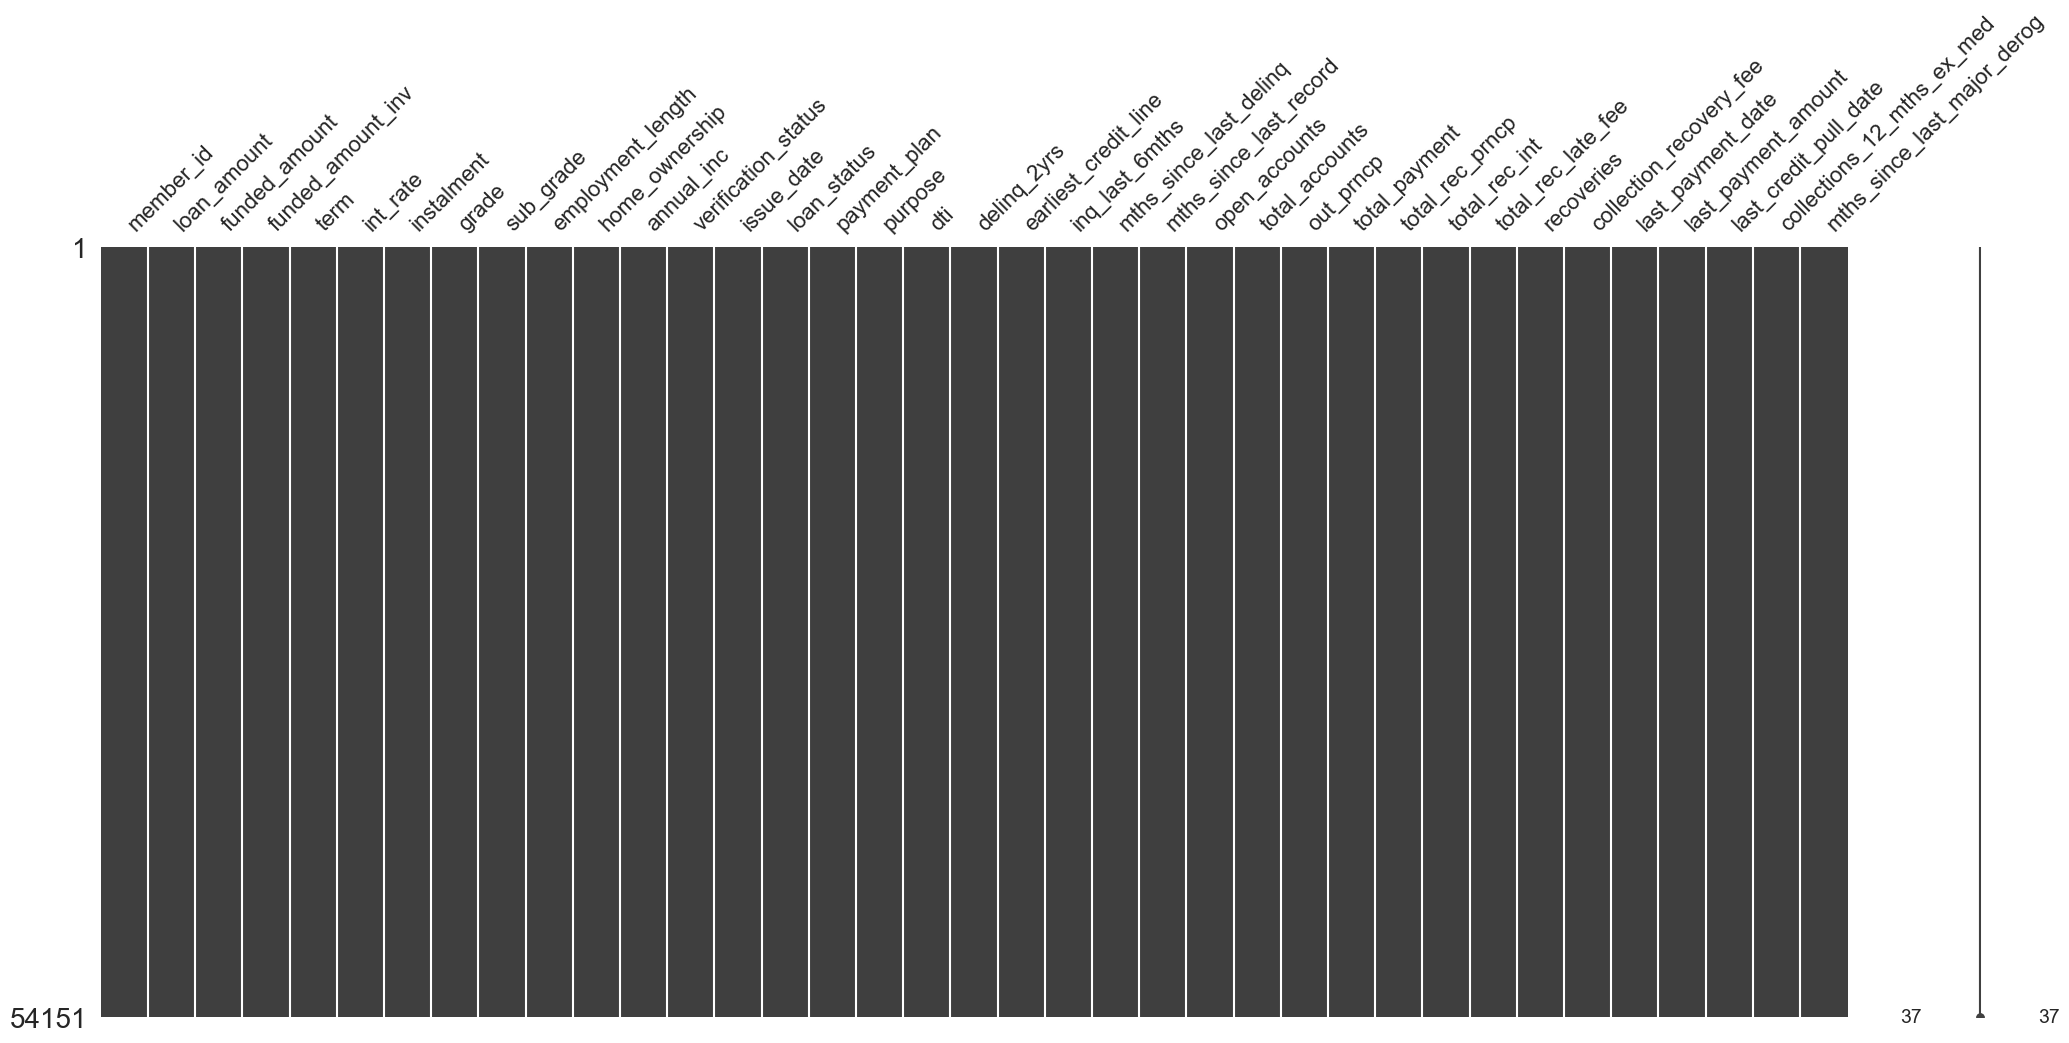

Saving to CSV in dir: c:\Users\prote\exploratory-data-analysis---customer-loans-in-finance/dataset/formatted_loan_data.csv
Completed Save


In [472]:
# Impute and further drop
# NMAR
# missing employment length likely means unemployed so impute 0

t_form = DataFrameTransform(df)

# Assume When Employment length is missing it means they don't have a job
t_form.impute_zeros(['employment_length'])
# mean interest rate since its within normal dist
t_form.impute_median(['int_rate', 'loan_amount', 'funded_amount'])

# these rows have insignificant null vals
t_form.drop_null_rows(['last_payment_date', 'last_credit_pull_date'])
plt = Plotter(t_form.df)
plt.missing_nulls_vis()

RDSDatabaseConnector.save_to_csv(
    t_form.df, "formatted_loan_data.csv")

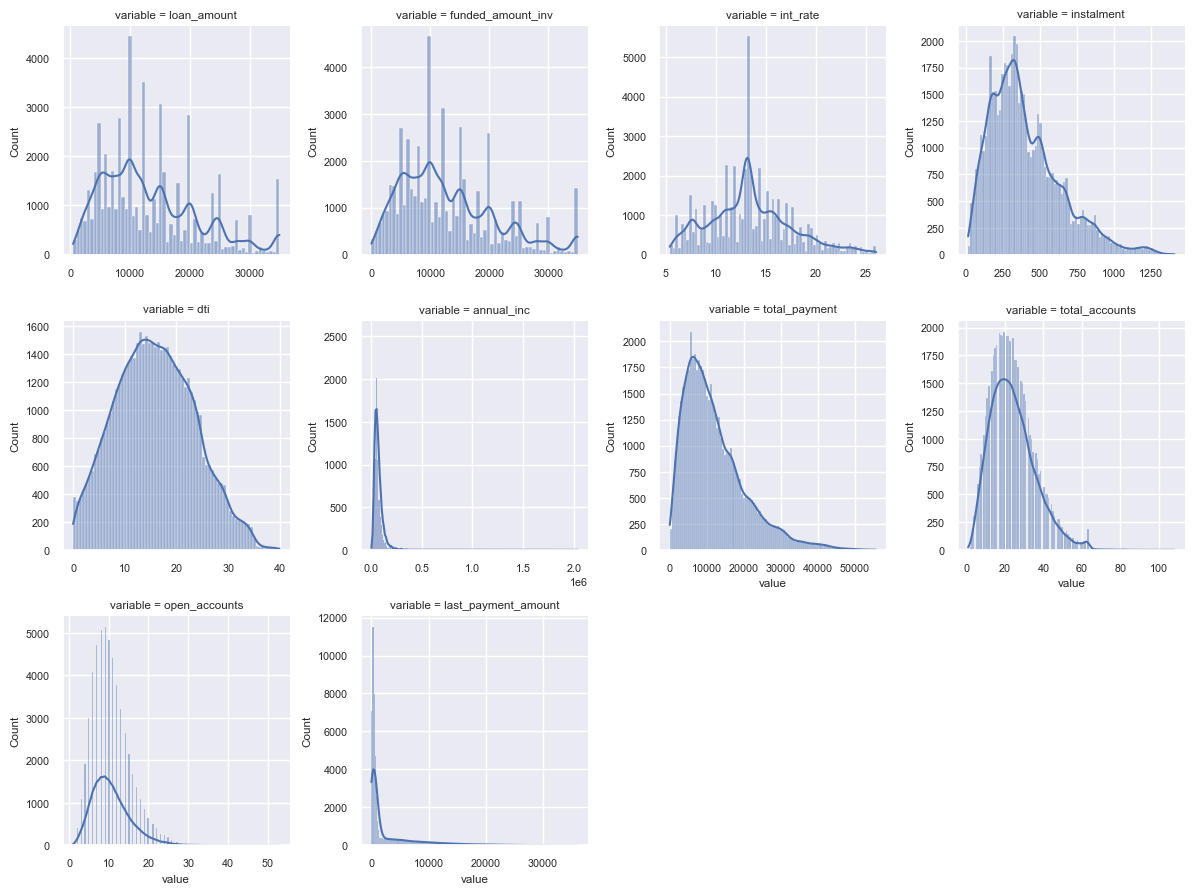

+---------------------+---------------------+
|       Column        |      Skewness       |
+---------------------+---------------------+
|     loan_amount     | 0.8049220181025606  |
|  funded_amount_inv  | 0.8133760847946324  |
|      int_rate       | 0.45661978102982004 |
|     instalment      | 0.9965721690437305  |
|         dti         | 0.18910057534680505 |
|     annual_inc      |  8.717499605870014  |
|    total_payment    | 1.2698752968451772  |
|   total_accounts    | 0.7790400286166349  |
|    open_accounts    | 1.0591835802494733  |
| last_payment_amount | 2.4972203995928135  |
+---------------------+---------------------+


In [473]:

# delinq appears more discrete than continuous so we dont include in skew analysis
numerical_cols = ['loan_amount',
                  'funded_amount_inv', 'int_rate', 'instalment', 'dti', 'annual_inc', 'total_payment', 'total_accounts', 'open_accounts', 'last_payment_amount']

plt.multi_hist_plot(numerical_cols)
Info.skew_data(numerical_cols)

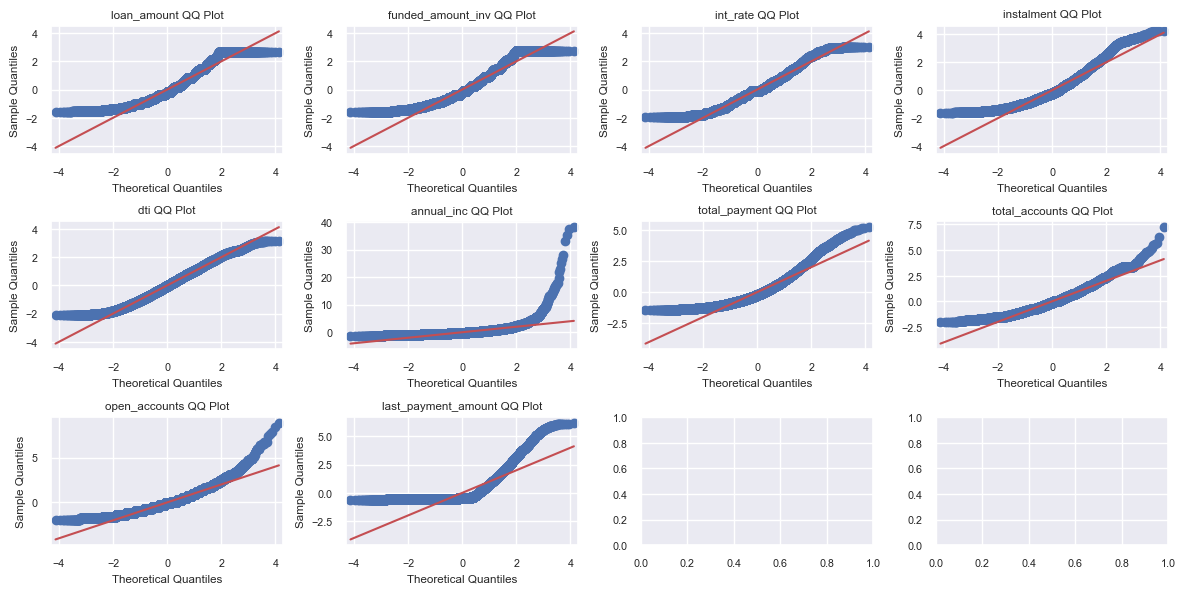

In [474]:
# All numerical data has high positive Skew

plt.multi_qq_plot(numerical_cols)

info = DataFrameInfo(t_form.df)

right_skewed_cols = ['annual_inc', 'total_payment', 'total_accounts',
                     'last_payment_amount', 'open_accounts', 'instalment', 'funded_amount_inv']

# As we can see the majority cols have almost exponential looking outliers

+---------------------+-----------------------+
|       Column        |       Skewness        |
+---------------------+-----------------------+
|     loan_amount     | -0.04307775783057989  |
|    total_payment    | -0.013814738044390004 |
|     instalment      | -0.020712390195657807 |
|      int_rate       | -0.01335284004413076  |
|         dti         |  -0.1257174261979297  |
|  funded_amount_inv  | -0.052401142306556805 |
|     annual_inc      |  0.1392027966594716   |
|   total_accounts    |  -2.468413596195364   |
|    open_accounts    | -0.47090032482861877  |
| last_payment_amount |  0.12803761707038572  |
+---------------------+-----------------------+


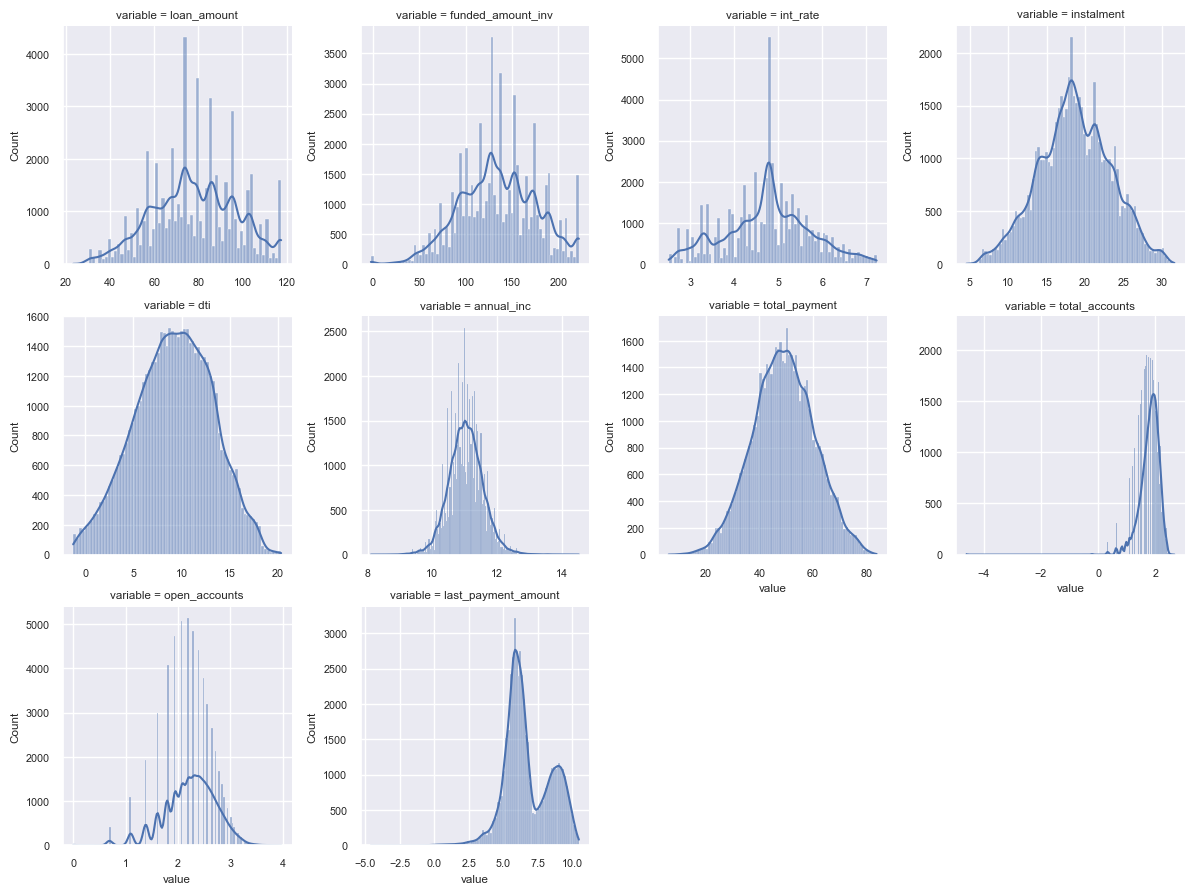

In [475]:
# Now the skew values are closer to 0 and we can apply
# Box cox transform
t_form.box_cox_transform(
    ['loan_amount', 'instalment', 'int_rate', 'total_accounts', 'dti', 'funded_amount_inv', 'total_payment'])

# Reduce impact of outliers
log_transform_cols = ['annual_inc', 'total_accounts',
                      'open_accounts', 'last_payment_amount']

t_form.log_transform(log_transform_cols)

Info.skew_data(
    ['loan_amount', 'total_payment', 'instalment', 'int_rate', 'dti', 'funded_amount_inv', 'annual_inc', 'total_accounts', 'open_accounts', 'last_payment_amount'])


plt.multi_hist_plot(numerical_cols)

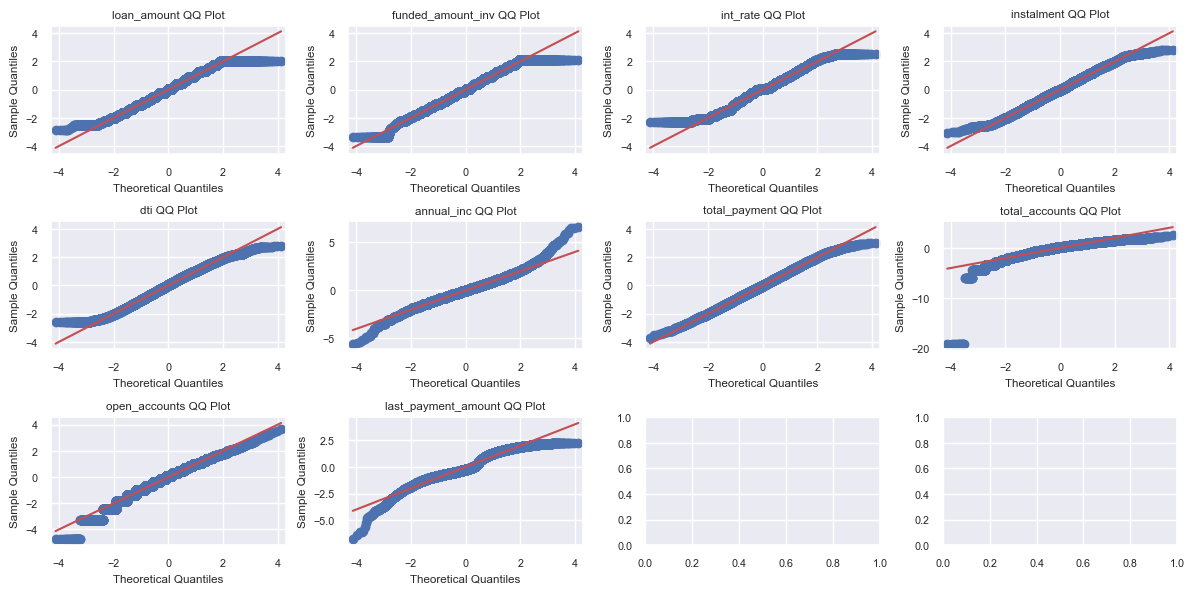

In [476]:
plt.multi_qq_plot(numerical_cols)

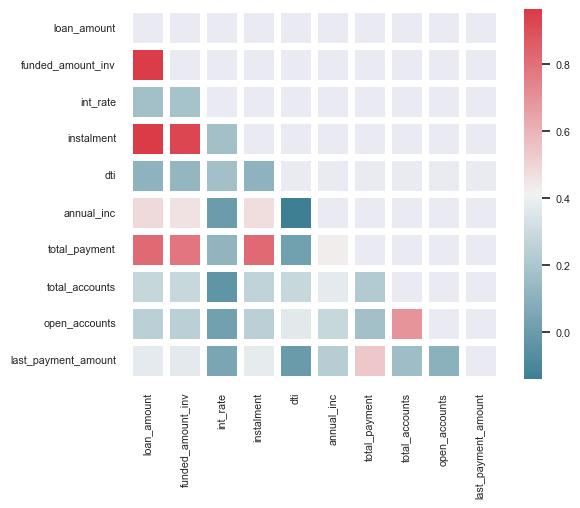

1.0006018873204674
Saving to CSV in dir: c:\Users\prote\exploratory-data-analysis---customer-loans-in-finance/dataset/transformed_data.csv
Completed Save


In [477]:
import statsmodels.formula.api as smf

plt.correlated_vars(numerical_cols)

model0 = smf.ols("funded_amount ~ funded_amount_inv", plt.df).fit()


def VIF(r2):
    return 1/(1-r2)


print(VIF(model0.rsquared))
RDSDatabaseConnector.save_to_csv(
    t_form.df, "transformed_data.csv")

# Analysis and Visualisation

1. Summarising what percentage of loans are recovered against investor funding currently.

In [478]:
from pandas.tseries.offsets import DateOffset

df = pd.read_csv("./dataset/formatted_loan_data.csv",
                 parse_dates=['issue_date', 'last_payment_date'])

# df['final_payment_date'] = df.apply(
#     lambda row: row['issue_date'] + DateOffset(months=row['term']), axis=1)


# Setup Mask


no_nill_invested = df['funded_amount_inv'] != 0

In [479]:
# If nill for funded_amount_inv (investors) use funded_amount (business)
original_df = df[~no_nill_invested]

df = df[no_nill_invested]

# Check If the loan is recovered
df['recovered_ratio'] = (
    df['total_payment'] / df['funded_amount_inv'])

original_df['recovered_ratio'] = (
    original_df['total_payment'] / df['funded_amount'])

# Recombine dataframes now with ratio
df = pd.concat([df, original_df], ignore_index=True)

# Convert to index for grouping
df['last_payment_date'] = pd.DatetimeIndex(df['last_payment_date'])

# Check if loan is recovered
df['recovered'] = df['recovered_ratio'].ge(1)
recovered_loans = df['recovered'] == True

# Filter by recovered loans
recovered_loan_df = df[recovered_loans]

percent_of_loans_recovered = round(len(recovered_loan_df) / len(df) * 100, 2)

print(f"Percent of Loans Currently Recovered: {percent_of_loans_recovered}%")

Percent of Loans Currently Recovered: 55.98%


In [480]:
# Check what Further can be recovered in 6 months
future_df = df[~recovered_loans]
prediction_df = df[~recovered_loans]
prediction_recovered_df = df[recovered_loans]
prediction_df['recovered'] = 0

future_df['6m_future_total_payment'] = future_df['total_payment'] + \
    (future_df['instalment'] * 6)

future_df['recovered'] = (future_df['6m_future_total_payment'] /
                          df['funded_amount_inv']).ge(1)

recovered_loans = future_df['recovered'] == True
recovered_loan_df_6m_future = future_df[recovered_loans]

percent_of_loans_recovered = round(
    len(recovered_loan_df_6m_future) / len(df) * 100, 2)

print(f"Percent of Loans Currently Recovered: {percent_of_loans_recovered}%")

Percent of Loans Currently Recovered: 16.86%


C:\Users\prote\AppData\Local\Temp\ipykernel_7712\3525490776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['recovered'] = 0
C:\Users\prote\AppData\Local\Temp\ipykernel_7712\3525490776.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_df['6m_future_total_payment'] = future_df['total_payment'] + \
C:\Users\prote\AppData\Local\Temp\ipykernel_7712\3525490776.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [481]:

# Group by month to count amount recovered that month


# filtered_df = recovered_loan_df.set_index('last_payment_date').groupby(
#     [pd.Grouper(freq="M")])['recovered'].count().reset_index()


# # Sort by date


# filtered_df.sort_values(by='last_payment_date', ascending=True, inplace=True)


# # Cumulative sum the percentage recovered per month ( recovered count / total recovered + unrecovered count )

# filtered_df['cumulative_sum'] = filtered_df['recovered'].apply(
#     lambda x: x / len(df) * 100).cumsum()

# filtered_df

In [482]:
# import matplotlib.pyplot as pyplot

# ax = pyplot.gca()
# pyplot.plot(filtered_df['last_payment_date'],
#             filtered_df['cumulative_sum'])
# pyplot.xlabel('Year Payments Recovered')
# pyplot.ylabel('Percent Recovered')
# pyplot.title('Time series repaid')

2. Project the query 6 months in the future based on instalments per month

In [483]:
prediction_df = prediction_df[[
    'last_payment_date', 'total_payment', 'instalment', 'funded_amount_inv', 'member_id', 'recovered']]


def add_months(df, col, nmonths):
    df[col] = df[col] + DateOffset(months=nmonths)


def add_nums(df, col, col_2):
    df[col] = df[col] + df[col_2]


def copy_and_mask_df(df, mask):
    return df[mask].copy()


# # Simulate payments and dates
months_to_predict = 6

prediction_df.sort_values(
    by='last_payment_date', ascending=False, inplace=True)

# reset all values to be the latest date payment was made
prediction_df['last_payment_date'] = prediction_df['last_payment_date'].iloc[0]

# prediction_df
for _ in range(months_to_predict):
    latest_date = prediction_df['last_payment_date'].max()

    mask = (prediction_df['last_payment_date'] == latest_date) & (
        prediction_df['recovered'] == False)

    copy_df = copy_and_mask_df(prediction_df, mask)

    add_nums(copy_df, 'total_payment', 'instalment')
    add_months(copy_df, 'last_payment_date', 1)

    copy_df['recovered'] = (
        copy_df['total_payment'] / copy_df['funded_amount_inv']) >= 1

    # copy_df = copy_df[copy_df['recovered'] == True]

    prediction_df = pd.concat([prediction_df, copy_df], ignore_index=True)


min_date = prediction_df['last_payment_date'].min()
prediction_df = prediction_df[prediction_df['last_payment_date'] > min_date]
prediction_df = prediction_df[prediction_df['recovered'] == True]

In [484]:
complete_df = pd.concat(
    [prediction_recovered_df, prediction_df], ignore_index=True)

# Group by month to count amount recovered that month
filtered_df = complete_df .set_index('last_payment_date').groupby(
    [pd.Grouper(freq="M")])['recovered'].count().reset_index()

# Sort by date
filtered_df.sort_values(
    by='last_payment_date', ascending=True, inplace=True)

# Cumulative sum the percentage recovered per month ( recovered count / total recovered + unrecovered count )
filtered_df['cumulative_sum'] = filtered_df['recovered'].apply(
    lambda x: x / (len(df)) * 100).cumsum()

filtered_df

,last_payment_date,recovered,cumulative_sum
0,2014-01-31,3,0.005540
1,2014-02-28,2,0.009233
2,2014-03-31,5,0.018467
3,2014-04-30,7,0.031394
4,2014-05-31,13,0.055401
5,2014-06-30,7,0.068327
6,2014-07-31,15,0.096028
7,2014-08-31,11,0.116341
8,2014-09-30,11,0.136655
9,2014-10-31,20,0.173589


In [485]:
print(filtered_df['recovered'].sum())

print(len(df))

39440
54151
